In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autotime

In [3]:
import os
import numpy as np

import pandas as pd
DF = pd.DataFrame

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [12, 4]

from tqdm import tqdm

time: 1.62 s


In [4]:
import torch
from torch import optim
from nbeats_pytorch.model import NBeatsNet
from torch.nn import functional as F

time: 1.04 s


# Generators, model, submission

In [16]:
def mk_train_gen(sa, TE, bcL, fcL, bs, es, align_monday):
    TS = np.argmax(sa>0, 0)
    if align_monday: 
        TS = (np.floor((TS+5)/7) * 7 + 2).astype(int)
        
    n_startpoints = (TE + 1 - bcL - TS).clip(min=0).astype(np.int)
    if align_monday: 
        n_startpoints = (np.floor((n_startpoints-1)/7)+1).astype(np.int)
    
    cum_startpoints = np.hstack([0, n_startpoints.cumsum()])
    
    for i in range(es): 
        ii = np.random.randint(cum_startpoints[-1], size=bs)
        jj = cum_startpoints.searchsorted(ii+1) - 1
        kk = ii - cum_startpoints[jj]
        if align_monday: 
            kk *= 7
        kk += TS[jj]
        #assert (kk + bcL <= TE).all()
        #if align_monday: 
        #    assert (cal['wday'].iloc[kk] == 3).all()

        samples = np.stack([sa[k:k+bcL+fcL, j] 
                            for k, j in zip(kk,jj)])
        yield samples[:, :bcL], samples[:, bcL:]
        
def mk_val_gen(sa, TE, bcL, fcL, bs, es, shuffle):
    ii = np.arange(sa.shape[1])
    if shuffle: np.random.shuffle(ii)
    for i in range(es):
        if i*bs > len(ii): # end of epoch
            break
        yield (sa[TE-bcL:TE, ii[i*bs:i*bs+bs]].T, 
                sa[TE:TE+fcL, ii[i*bs:i*bs+bs]].T)

time: 4.03 ms


In [9]:
def mk_acc_submission(fc1, fc2, cols, fn, message=None):
    output = DF(
        np.vstack([fc1.T, fc2.T]), 
        index = [c+'_'+s for s in ['validation', 'evaluation']
                             for c in cols], 
        columns = [f'F{i+1}' for i in range(28)]
    )
    output.index.name='id'
    output.reset_index().to_csv(f'../output/{fn}.csv', index=False)
    output.reset_index().to_csv(f'../output/{fn}.csv.gz', index=False, 
                                compression='gzip')
    if message is not None:
        print ('Submit? [yes/no]')
        ans = input()
        if ans == 'yes':
            print ('submitting...')
            cmd = 'kaggle competitions submit ' \
                    '-c m5-forecasting-accuracy ' \
                    f'-f ../output/{fn}.csv.gz -m "{message}"'
            print (cmd)
            import subprocess
            return subprocess.check_output(cmd, shell=True)
        else:
            print ('do not submit')

time: 2.82 ms


In [49]:
class ResMLP(torch.nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers, dropout):
        super(ResMLP, self).__init__()
        dims = [n_input] + [n_hidden] * (n_layers-1) + [n_output]
        self.layers = [torch.nn.Linear(i, o) 
                           for i, o in zip(dims[:-1], dims[1:])]
        self.dropout = dropout
        
        params = []
        for l in self.layers:
            params.extend(l.parameters())
        self.parameters = torch.nn.ParameterList(params)
        
    def forward(self, x):
        x0 = x
        for i in range(len(self.layers)):
            x = torch.nn.Dropout(self.dropout)(
                    torch.nn.ReLU()(
                        self.layers[i](x)
                    )
                )
        return x0[:, -self.layers[-1].out_features:] + x
        #return x0 + 0 * x  # reproduce simple forecast

time: 2.67 ms


In [27]:
def tttd(x):
    return torch.tensor(x, dtype=torch.float).to(device)

time: 997 µs


# Data Loading

In [7]:
# Loading data
sales = pd.read_feather('../data/m5-forecasting/sales.feather')
inp_scale = sales.values.max(0)
sa = sales.values / inp_scale[None, :]

cal = pd.read_feather('../data/m5-forecasting/cal.feather')
prices = pd.read_feather('../data/m5-forecasting/prices.feather')

time: 4.04 s


# Params

In [67]:
# Data preprocessing params
fcL = 28
bcL = 1 * fcL
align_monday = True

# Model params
n_hidden = 200
n_layers = 3
dropout = 0.3

# Training params
trn_bs = 1000
trn_es = 100

val_bs = 1000
val_es = 33 # val_bs * val_es > dataset

lr = 1e-3
epochs = 150

# Runtime params
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

time: 1.78 ms


In [68]:
# Derived params
DE = len(sa)  # Data End
TE = DE - fcL  # Train period End

time: 876 µs


# Training

In [69]:
model = ResMLP(bcL, fcL, n_hidden, n_layers, dropout)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

time: 4.39 ms


In [70]:
trn_loss = []
val_loss = []

time: 832 µs


In [71]:
for epoch in tqdm(range(epochs)):
    
    model.train()
    batch_loss = []
    trn_gen = mk_train_gen(sa, TE, bcL, fcL, trn_bs, trn_es, align_monday)
    for x, y in trn_gen:
        yh = model(tttd(x))
        loss = loss_fn(yh, tttd(y))
        batch_loss += [loss.item()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trn_loss += [np.mean(batch_loss)]
        
    model.eval()
    batch_loss = []
    val_gen = mk_val_gen(sa, TE, bcL, fcL, val_bs, val_es, False)
    for x, y in val_gen:
        yh = model(tttd(x))
        loss = loss_fn(yh, tttd(y))
        batch_loss += [loss.item()]
    val_loss += [np.mean(batch_loss)]
        

100%|██████████| 150/150 [04:21<00:00,  1.74s/it]

time: 4min 21s


(0.02956670954823494, 0.033500375406396006)

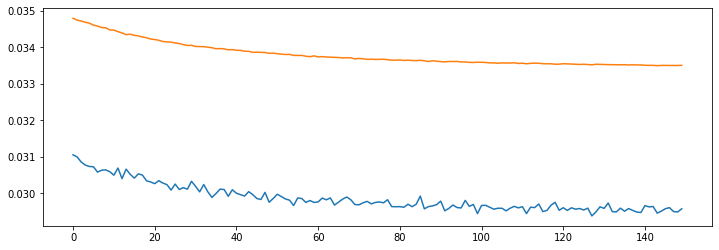

time: 277 ms


In [72]:
plt.plot(trn_loss)
plt.plot(val_loss)
trn_loss[-1], val_loss[-1]

(0.029923066720366476, 0.033886062401917674)

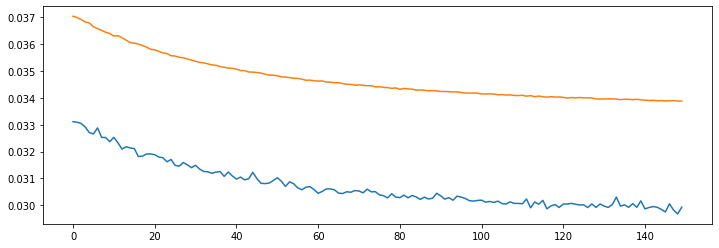

time: 362 ms


In [66]:
plt.plot(trn_loss)
plt.plot(val_loss)
trn_loss[-1], val_loss[-1]

(0.030128711462020875, 0.03404588678911809)

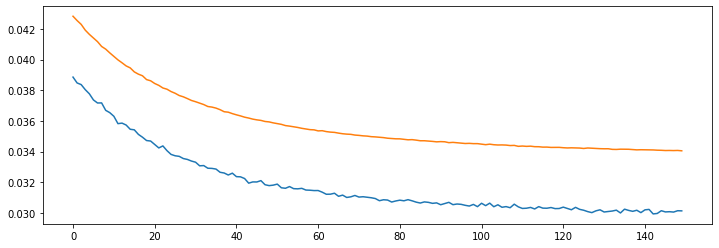

time: 270 ms


In [59]:
plt.plot(trn_loss)
plt.plot(val_loss)
trn_loss[-1], val_loss[-1]

(0.03126842584460974, 0.03534523007129469)

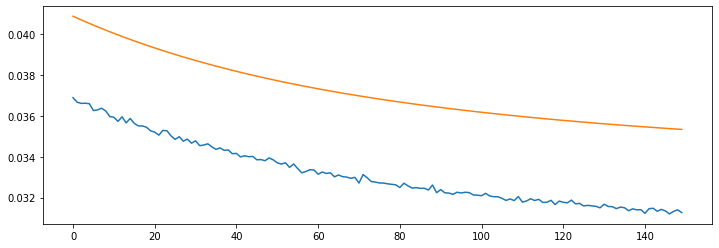

time: 277 ms


In [44]:
plt.plot(trn_loss)
plt.plot(val_loss)
trn_loss[-1], val_loss[-1]

(0.029061670023947953, 0.03336747098834284)

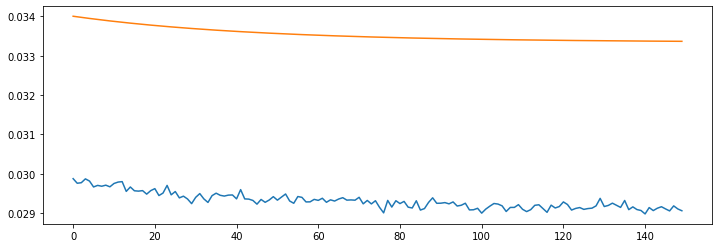

time: 222 ms


In [33]:
plt.plot(trn_loss)
plt.plot(val_loss)
trn_loss[-1], val_loss[-1]

In [73]:
tst_gen = mk_val_gen(sa, DE, bcL, fcL, val_bs, 99999, False)
fc = []
for x, y in tst_gen:
    yh = model(tttd(x))
    fc += [yh.data.numpy()]
fc = np.vstack(fc).T    

time: 243 ms


In [75]:
mk_acc_submission(np.round(fc*inp_scale, 0), fc*0, sales.columns, 
                  '2-mlp-test', 
                  'Does rounding improve the score?'
                 )

Submit? [yes/no]
yes
submitting...
kaggle competitions submit -c m5-forecasting-accuracy -f ../output/2-mlp-test.csv.gz -m "Does rounding improve the score?"


b'Successfully submitted to M5 Forecasting - Accuracy'

time: 17.9 s
